## Install and import

In [55]:
!pip install datasets transformers attrdict

In [56]:
import torch
import torch.nn as nn
from transformers import BertPreTrainedModel, BertModel
from transformers import BertTokenizer
from typing import Union, Optional

import numpy as np
from transformers.pipelines import ArgumentHandler
from transformers import (
    Pipeline,
    PreTrainedTokenizer,
    ModelCard
)
from pprint import pprint
import os
import google.colab as colab
import pandas as pd
import json
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import random
from attrdict import AttrDict
from torch.utils.data import SequentialSampler, DataLoader

import os
import copy
import json
import logging

import torch
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm

In [57]:
def mount_google_drive():
	'''
	# Functionality
		Mount google drive. Since colab does not save files, we want to make it easier to directly access files in google drive.
	# Arguments
		Nothing
	# Returns
		drive_root: the working directory mounted
	'''
	mount_directory = "/content/gdrive"
	drive = colab.drive
	drive.mount(mount_directory, force_remount=True)
	drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0]
	return drive_root

ROOT_DIR =  mount_google_drive() + "/goemotion/"
CHECKPOINT_ROOT = ROOT_DIR + "xinwen_ckpt/checkpoint-8000"

Mounted at /content/gdrive


## DataLoader

In [58]:


logger = logging.getLogger(__name__)


class InputExample(object):
    """ A single training/test example for simple sequence classification. """

    def __init__(self, guid, text_a, text_b, label):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, attention_mask, token_type_ids, label):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"


def convert_examples_to_features(
        args,
        examples,
        tokenizer,
        max_length,
):
    processor = GoEmotionsProcessor(args)
    label_list_len = len(processor.get_labels())

    def convert_to_one_hot_label(label):
        one_hot_label = [0] * label_list_len
        for l in label:
            one_hot_label[l] = 1
        return one_hot_label

    labels = [convert_to_one_hot_label(example.label) for example in examples]

    batch_encoding = tokenizer.batch_encode_plus(
        [(example.text_a, example.text_b) for example in examples], max_length=max_length, pad_to_max_length=True
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

    for i, example in enumerate(examples[:10]):
        logger.info("*** Example ***")
        logger.info("guid: {}".format(example.guid))
        logger.info("sentence: {}".format(example.text_a))
        logger.info("tokens: {}".format(" ".join([str(x) for x in tokenizer.tokenize(example.text_a)])))
        logger.info("input_ids: {}".format(" ".join([str(x) for x in features[i].input_ids])))
        logger.info("attention_mask: {}".format(" ".join([str(x) for x in features[i].attention_mask])))
        logger.info("token_type_ids: {}".format(" ".join([str(x) for x in features[i].token_type_ids])))
        logger.info("label: {}".format(" ".join([str(x) for x in features[i].label])))

    return features


class GoEmotionsProcessor(object):
    """Processor for the GoEmotions data set """

    def __init__(self, args):
        self.args = args

    def get_labels(self):
        labels = []
        with open(os.path.join(self.args.data_dir, self.args.label_file), "r", encoding="utf-8") as f:
            for line in f:
                labels.append(line.rstrip())
        return labels
    
    def obtain_label_text(self):
        label_list = self.get_labels()
        for i in range(len(label_list)):
            if label_list[i] == 'optimism':
                label_list[i] = 'optimistic'
            elif label_list[i] == 'nervousness':
                label_list[i] = 'nervous'
        label_text = ' '.join(label_list)
        self.label_text = label_text
        self.label_length = len(label_list)
        return

    @classmethod
    def _read_file(cls, input_file):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            return f.readlines()

    def _create_examples(self, lines, set_type):
        """ Creates examples for the train, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            line = line.strip()
            items = line.split("\t")
            text_b = items[0]
            label = list(map(int, items[1].split(",")))
            if i % 5000 == 0:
                logger.info(line)
            examples.append(InputExample(guid=guid, text_a=self.label_text, text_b=text_b, label=label))
        return examples

    def get_examples(self, mode):
        """
        Args:
            mode: train, dev, test
        """
        file_to_read = None
        if mode == 'train':
            file_to_read = self.args.train_file
        elif mode == 'dev':
            file_to_read = self.args.dev_file
        elif mode == 'test':
            file_to_read = self.args.test_file
        elif mode == 'new':
            file_to_read = self.args.new_file

        logger.info("LOOKING AT {}".format(os.path.join(self.args.data_dir, file_to_read)))
        return self._create_examples(self._read_file(os.path.join(self.args.data_dir,
                                                                  file_to_read)), mode)


def load_and_cache_examples(args, tokenizer, mode):
    processor = GoEmotionsProcessor(args)
    processor.obtain_label_text()
    # Load data features from cache or dataset file
    cached_features_file = os.path.join(
        args.data_dir,
        "cached_{}_{}_{}_{}".format(
            str(args.task),
            list(filter(None, args.model_name_or_path.split("/"))).pop(),
            str(args.max_seq_len),
            mode
        )
    )
    if os.path.exists(cached_features_file):
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
        candidate_examples = processor.get_examples("new")
        candidate_features = convert_examples_to_features(
            args, candidate_examples, tokenizer, max_length=args.max_seq_len+processor.label_length
        )
    else:
        logger.info("Creating features from dataset file at %s", args.data_dir)
        if mode == "train":
            examples = processor.get_examples("train")
        elif mode == "dev":
            examples = processor.get_examples("dev")
        elif mode == "test":
            examples = processor.get_examples("test")
        elif mode == "new":
            examples = processor.get_examples("new")
        else:
            raise ValueError("For mode, only train, dev, test, new is available")
        features = convert_examples_to_features(
            args, examples, tokenizer, max_length=args.max_seq_len+processor.label_length
        )
        candidate_examples = processor.get_examples("new")
        candidate_features = convert_examples_to_features(
            args, candidate_examples, tokenizer, max_length=args.max_seq_len+processor.label_length
        )
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.float)
    candidate_input_ids = torch.tensor([f.input_ids for f in candidate_features], dtype=torch.long)
    candidate_attention_mask = torch.tensor([f.attention_mask for f in candidate_features], dtype=torch.long)
    candidate_token_type_ids = torch.tensor([f.token_type_ids for f in candidate_features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels, candidate_input_ids, candidate_attention_mask, candidate_token_type_ids)
    return dataset

## Model Class

In [59]:
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.pool_classifier = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh(),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.hidden_size, 1)
        )
        # self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.loss_fct = nn.BCEWithLogitsLoss()

        self.init_weights()
        self.mixing_rate = 0.92

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            candidate_input_ids=None,
            candidate_attention_mask=None,
            candidate_token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        if candidate_input_ids is not None and candidate_attention_mask is not None and candidate_token_type_ids is not None:
          candidate_outputs = self.bert(
              candidate_input_ids,
              attention_mask=candidate_attention_mask,
              token_type_ids=candidate_token_type_ids,
              position_ids=position_ids,
              head_mask=head_mask,
              inputs_embeds=inputs_embeds
          )
          temp = self.mixing_rate * outputs[0] + (1 - self.mixing_rate) * candidate_outputs[0]
          last_hidden_state = temp[:, 1:self.config.num_labels+1] # only get the states corresponding to labels
        else:
          last_hidden_state = outputs[0][:, 1:self.config.num_labels+1] # only get the states corresponding to labels

        logits = self.pool_classifier(last_hidden_state).squeeze(-1)

        # pooled_output = outputs[1]
        # pooled_output = self.dropout(pooled_output)
        # logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            loss = self.loss_fct(logits, labels)
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

# Pipeline

In [60]:
class MultiLabelTestInferencePipeline(Pipeline):
    def __init__(
            self,
            model: Union["PreTrainedModel", "TFPreTrainedModel"],
            tokenizer: PreTrainedTokenizer,
            modelcard: Optional[ModelCard] = None,
            framework: Optional[str] = None,
            task: str = "",
            args_parser: ArgumentHandler = None,
            device: int = -1,
            binary_output: bool = False,
            threshold: float = 0.3,
            taxonomy = "original"
    ):
        super().__init__(
            model=model,
            tokenizer=tokenizer,
            modelcard=modelcard,
            framework=framework,
            args_parser=args_parser,
            device=device,
            binary_output=binary_output,
            task=task
        )

        self.threshold = threshold

        # config_filename = "{}.json".format(taxonomy)
        # with open(os.path.join("config", config_filename)) as f:
        #     args = AttrDict(json.load(f))
        orig_dict = {
        "task": "goemotions",
        "data_dir": ROOT_DIR + "data/original",
        "ckpt_dir": ROOT_DIR + "ckpt/original",
        "output_dir": "bert-base-cased-goemotions-original",
        "train_file": "train.tsv",
        "dev_file": "dev.tsv",
        "test_file": "test.tsv",
        "new_file": "new.tsv",
        "label_file": "labels.txt",
        "evaluate_test_during_training": False,
        "eval_all_checkpoints": True,
        "save_optimizer": False,
        "do_lower_case": False,
        "do_train": True,
        "do_eval": True,
        "max_seq_len": 50,
        "num_train_epochs": 4,
        "weight_decay": 0.0,
        "gradient_accumulation_steps": 1,
        "adam_epsilon": 1e-8,
        "warmup_proportion": 0.1,
        "max_steps": -1,
        "max_grad_norm": 1.0,
        "no_cuda": False,
        "model_type": "bert",
        "model_name_or_path": "bert-base-cased",
        "tokenizer_name_or_path": "monologg/bert-base-cased-goemotions-original",
        "seed": 42,
        "train_batch_size": 16,
        "eval_batch_size": 32,
        "logging_steps": 1000,
        "save_steps": 1000,
        "learning_rate": 5e-5,
        "threshold": 0.3
        }
        args = AttrDict(orig_dict)

        args.output_dir = os.path.join(args.ckpt_dir, args.output_dir)

        processor = GoEmotionsProcessor(args)
        label_list = processor.get_labels()

        args.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
        model.to(args.device)

        eval_dataset = load_and_cache_examples(args, tokenizer, mode="test") if args.test_file else None
        eval_sampler = SequentialSampler(eval_dataset)
        self.eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

        self.args = args
        self.model = model

    def __call__(self, *args, **kwargs):

        results = []
        ground_truths = []
        for batch in tqdm(self.eval_dataloader):
            self.model.eval()
            for label in batch[3]:
                label_text = []
                idxs = np.where(label.numpy() == 1.0)[0]
                for idx in idxs:
                    label_text.append(self.model.config.id2label[idx])
                ground_truths.append(label_text)
            batch = tuple(t.to(self.args.device) for t in batch)

            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                    "labels": batch[3],
                    "candidate_input_ids": batch[4],
                    "candidate_attention_mask": batch[5],
                    "candidate_token_type_ids": batch[6]
                }
                outputs = self.model(**inputs)[1].detach().cpu()

            scores = 1 / (1 + np.exp(-outputs))  # Sigmoid
            for item in scores:
                labels = []
                scores = []
                for idx, s in enumerate(item):
                    if s > self.threshold:
                        labels.append(self.model.config.id2label[idx])
                        scores.append(float(s))
                results.append({"labels": labels, "scores": scores})

        return results, ground_truths

# Inference On Testset

In [61]:
tokenizer = BertTokenizer.from_pretrained(CHECKPOINT_ROOT)
model = BertForMultiLabelClassification.from_pretrained(CHECKPOINT_ROOT)

goemotions = MultiLabelTestInferencePipeline(
    model=model,
    tokenizer=tokenizer,
    threshold=0.3
)

raw_predictions, ground_truths = goemotions()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [62]:
# Load training sentences
train_df = pd.read_csv(ROOT_DIR + "data/original/train.tsv", sep='\t', header=None, names=["sentence", "label", "encoding"])
train_sentences = train_df.sentence.tolist()

# Load labels and build dicts
with open(ROOT_DIR + "data/original/labels.txt", "r") as f:
  labels = f.read().splitlines()
label2index = {v: k for k, v in enumerate(labels)}
index2label = {k: v for k, v in enumerate(labels)}


# Load test set, get test sents and ground truths
test_df = pd.read_csv(ROOT_DIR + "data/original/test.tsv", sep='\t', header=None, names=["sentence", "label", "encoding"])
test_sentences = test_df.sentence.tolist()


# Create ground truth label format
ground_truths = []
for x in test_df.label.tolist():
  single_idxs = x.split(",")
  single_labels = []
  for label in single_idxs:
    single_labels.append(index2label[int(label)])
  ground_truths.append(single_labels)

In [63]:
predictions = [x["labels"] for x in raw_predictions]

In [64]:
assert len(ground_truths) == len(predictions)

In [65]:
num_em = 0
for i, (pred, truth) in enumerate(zip(predictions, ground_truths)):
  if pred == truth:
    num_em += 1
print(num_em / len(predictions))

0.43191450156624284


In [66]:
def convert_onehot(inputs):
  final_arr = np.zeros((len(inputs), len(label2index.keys())))
  for i, labels in enumerate(inputs):
    for label in labels:
      final_arr[i, label2index[label]] = 1
  return final_arr

In [67]:
onehot_truths = convert_onehot(ground_truths)
onehot_preds = convert_onehot(predictions)
multilabel_confmat = multilabel_confusion_matrix(onehot_truths, onehot_preds)

In [68]:
cls_report = {}
for i in range(multilabel_confmat.shape[0]):
  cls_report[index2label[i]] = {}
  cls_report[index2label[i]]["tn"] = multilabel_confmat[i, 0, 0] + 1
  cls_report[index2label[i]]["fp"] = multilabel_confmat[i, 0, 1] + 1
  cls_report[index2label[i]]["fn"] = multilabel_confmat[i, 1, 0] + 1
  cls_report[index2label[i]]["tp"] = multilabel_confmat[i, 1, 1] + 1
  cls_report[index2label[i]]["total"] = cls_report[index2label[i]]["tp"] + cls_report[index2label[i]]["fn"]
  cls_report[index2label[i]]["precision"] = cls_report[index2label[i]]["tp"] / (cls_report[index2label[i]]["fp"] + cls_report[index2label[i]]["tp"])
  cls_report[index2label[i]]["recall"] = cls_report[index2label[i]]["tp"] / (cls_report[index2label[i]]["fn"] + cls_report[index2label[i]]["tp"])
  cls_report[index2label[i]]["f1"] = 2 * cls_report[index2label[i]]["precision"] * cls_report[index2label[i]]["recall"] / (cls_report[index2label[i]]["precision"] + cls_report[index2label[i]]["recall"])

In [69]:
cls_report

{'admiration': {'f1': 0.6834264432029795,
  'fn': 139,
  'fp': 201,
  'precision': 0.6461267605633803,
  'recall': 0.7252964426877471,
  'tn': 4724,
  'total': 506,
  'tp': 367},
 'amusement': {'f1': 0.82,
  'fn': 20,
  'fp': 88,
  'precision': 0.7365269461077845,
  'recall': 0.924812030075188,
  'tn': 5077,
  'total': 266,
  'tp': 246},
 'anger': {'f1': 0.5346062052505968,
  'fn': 88,
  'fp': 107,
  'precision': 0.5114155251141552,
  'recall': 0.56,
  'tn': 5124,
  'total': 200,
  'tp': 112},
 'annoyance': {'f1': 0.38255033557046986,
  'fn': 208,
  'fp': 160,
  'precision': 0.41605839416058393,
  'recall': 0.35403726708074534,
  'tn': 4949,
  'total': 322,
  'tp': 114},
 'approval': {'f1': 0.3827493261455525,
  'fn': 211,
  'fp': 247,
  'precision': 0.36503856041131105,
  'recall': 0.40226628895184136,
  'tn': 4831,
  'total': 353,
  'tp': 142},
 'caring': {'f1': 0.42320819112627983,
  'fn': 75,
  'fp': 94,
  'precision': 0.3974358974358974,
  'recall': 0.45255474452554745,
  'tn': 52

In [70]:
def get_attr_class(cls_report, metric_name):
  return [x[metric_name] for x in list(cls_report.values())]

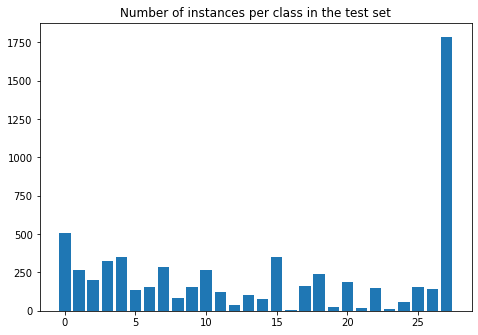

In [71]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Number of instances per class in the test set')
metric_name = "total"
ax.bar(list(label2index.values()), [x[metric_name] for x in list(cls_report.values())])
plt.show()

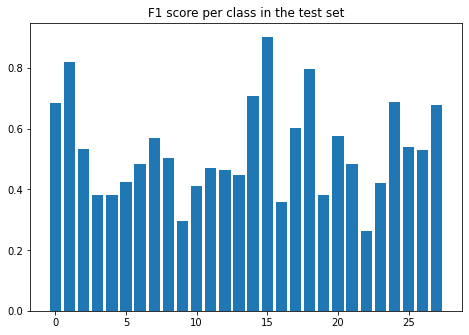

In [72]:
# make two columns
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('F1 score per class in the test set')
metric_name = "f1"
ax.bar(list(label2index.values()), [x[metric_name] for x in list(cls_report.values())])
plt.show()

In [73]:
sum([x[metric_name] for x in list(cls_report.values())]) / len([x[metric_name] for x in list(cls_report.values())])

0.5287009200015446